In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mapping reads

bowtie2 -x ~/data/indexes/bowtie2/mm10/mm10 -U CTCF_ER4.fastq > CTCF_ER4_mapped.sam

bowtie2 -x ~/data/indexes/bowtie2/mm10/mm10 -U CTCF_G1E.fastq > CTCF_G1E_mapped.sam

bowtie2 -x ~/data/indexes/bowtie2/mm10/mm10 -U input_ER4.fastq > input_ER4_mapped.sam

bowtie2 -x ~/data/indexes/bowtie2/mm10/mm10 -U input_G1E.fastq > input_G1E_mapped.sam

# Calling Peaks

macs2 callpeak -t CTCF_ER4_mapped.sam -c input_ER4_mapped.sam --name=ER4 --gsize=138000000 --bdg

macs2 callpeak -t CTCF_G1E_mapped.sam -c input_G1E_mapped.sam --name=G1E --gsize=138000000 --bdg


# Differential Binding

bedtools subtract -A -a ER4_peaks.narrowPeak -b G1E_peaks.narrowPeak > diff1.bed

bedtools subtract -A -a G1E_peaks.narrowPeak -b ER4_peaks.narrowPeak > diff2.bed

# Feature Overlapping

wget https://raw.githubusercontent.com/bxlab/qbb2020/master/week5/Mus_musculus.GRCm38.94_features.bed

bedtools intersect -a Mus_musculus.GRCm38.94_features.bed -b ER4_peaks.narrowPeak > overlap_ER4.bed

bedtools intersect -a Mus_musculus.GRCm38.94_features.bed -b G1E_peaks.narrowPeak > overlap_G1E.bed



# Count how many of the CTCF binding sites in G1E and ER4 overlap with each feature 

cut -f 4 overlap_G1E.bed|sort|uniq -c > G1Ecount.txt

cut -f 4 overlap_ER4.bed|sort|uniq -c > ER4count.txt

In [5]:
G1Ecounts = pd.read_csv('G1Ecount.txt', header = None, sep = '\s+')
G1Ecounts.columns = ['G1Ecount','feature']
G1Ecounts

,G1Ecount,feature
0,65,exon
1,226,intron
2,41,promoter


In [6]:
ER4counts = pd.read_csv('ER4count.txt', header = None, sep = '\s+')
ER4counts.columns = ['ER4count','feature']
ER4counts

,ER4count,feature
0,82,exon
1,276,intron
2,53,promoter


In [7]:
merge_df = G1Ecounts.merge(ER4counts, on = ['feature'])
merge_df

,G1Ecount,feature,ER4count
0,65,exon,82
1,226,intron,276
2,41,promoter,53


# Sites lost and gained during differentiation for each cell type

bedtools intersect -v -a G1E_peaks.narrowPeak -b ER4_peaks.narrowPeak > loss.bed

bedtools intersect -v -a ER4_peaks.narrowPeak -b G1E_peaks.narrowPeak > gain.bed

 wc -l loss.bed > loss_gained.txt
 
 wc -l gain.bed >> loss_gained.txt

In [8]:
lossgain = pd.read_csv('loss_gained.txt', header = None, sep = '\s+')
lossgain.columns = ['Count','Loss or gain']
lossgain

,Count,Loss or gain
0,25,loss.bed
1,124,gain.bed


# Plot

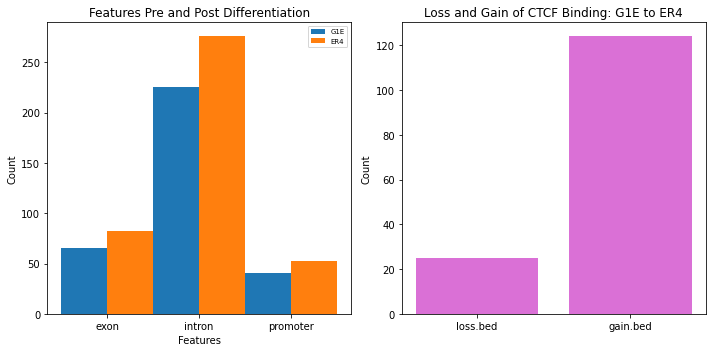

In [19]:
label = ["exon","intron","promoter"]
x = np.arange(len(label))  # the label locations
width = 0.50

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

rects1 = ax[0].bar(x - width/2, merge_df['G1Ecount'], width, label='G1E')
rects2 = ax[0].bar(x + width/2, merge_df['ER4count'], width, label='ER4')
ax[0].set_title('Features Pre and Post Differentiation')
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Count')
ax[0].set_xticks(x)
ax[0].set_xticklabels(label)
ax[0].legend(loc='upper right', prop={'size': 7})

ax[1].bar(lossgain['Loss or gain'],lossgain['Count'], color = 'orchid')
ax[1].set_title('Loss and Gain of CTCF Binding: G1E to ER4')
ax[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# Motif Discovery

# Select 100 Strongest Peaks from ER4 state 

sort -k8 -nr ER4_peaks.narrowPeak > ER4_sorted.narrowPeak

head -n 100 ER4_sorted.narrowPeak > ER4_top100.narrowPeak

# Map to reference

bedtools getfasta -fi /Users/cmdb/data/genomes/mm10.fa -bed ER4_top100.narrowPeak > ER4_top100.fa

# Used this output in meme chip

meme-chip -maxw 20 -db JASPAR2018_CORE_non-redundant_pfms_meme/MA* ER4_top100.fa

# Uploaded resulting combined.meme file to tomtom

wget https://bx.bio.jhu.edu/data/msauria/cmdb-lab/JASPAR2018_CORE_non-redundant_pfms_meme.zip

tomtom logo plot for motif MA0139.1 (CTCF) pushed to github